In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
from torchvision.io import read_image

In [4]:
import os

import torch
from torch.utils.data import Dataset


class FaceDataset(Dataset):
    def __init__(
        self,
        img_dir="data/UTKFace/train",
        transform=None,
        target_transform=None,
    ):

        self.transform = transform
        self.target_transform = target_transform

        self.img_paths = []
        self.labels = []
        self.gender = [] # 0 (male) or 1 (female)
        self.race = [] # 0 to 4, denoting White, Black, Asian, Indian, and Others 

        for filename in os.listdir(img_dir):
            self.img_paths.append(os.path.join(img_dir, filename))
            self.labels.append(
                int(filename.split("_")[0])
            )  # age is element of filename

            self.gender.append(
                int(filename.split("_")[1])
            )

            self.race.append(
                int(filename.split("_")[2][0])
            )

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = read_image(self.img_paths[idx])
        label = self.labels[idx]
        label = torch.FloatTensor([label])

        if self.transform:
            img = self.transform(img)

        if self.target_transform:
            label = self.target_transform(label)

        return img, label

In [66]:
np.clip(2,a_min=0,a_max=100)

2

In [5]:
dataset = FaceDataset(img_dir="data/UTKFace")

In [6]:
df = pd.DataFrame({"age":dataset.labels,"race":dataset.race,"gender":dataset.gender,"path":dataset.img_paths})
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     23708 non-null  int64 
 1   race    23708 non-null  int64 
 2   gender  23708 non-null  int64 
 3   path    23708 non-null  object
dtypes: int64(3), object(1)
memory usage: 741.0+ KB
None


In [7]:
df.age.max()

116

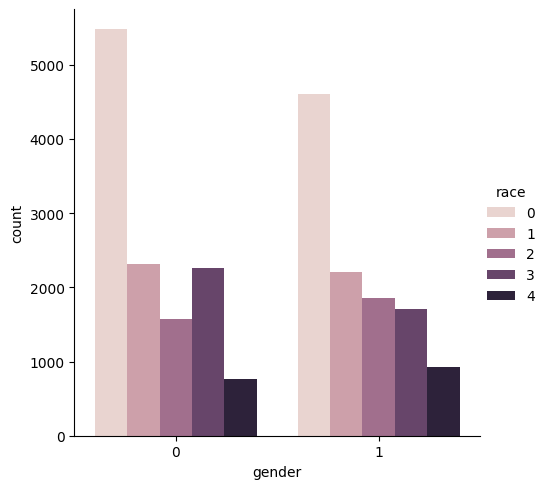

In [8]:
sns.catplot(data=df,x="gender",hue="race",kind="count")

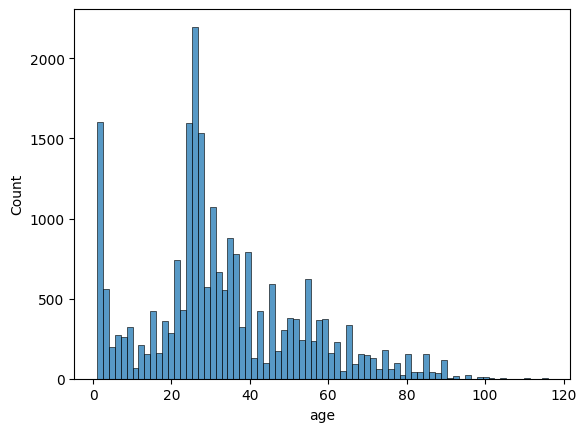

In [9]:
sns.histplot(data=df,x="age")
plt.savefig("age_distr.png")

In [10]:
df["gender"]=df.gender.map({0:"Male",1:"Female"})

In [11]:
df["race"]=df.race.map({0:"White",1:"Black",2:"Asian",3:"Indian",4:"Others"})

<Axes: xlabel='age', ylabel='Count'>

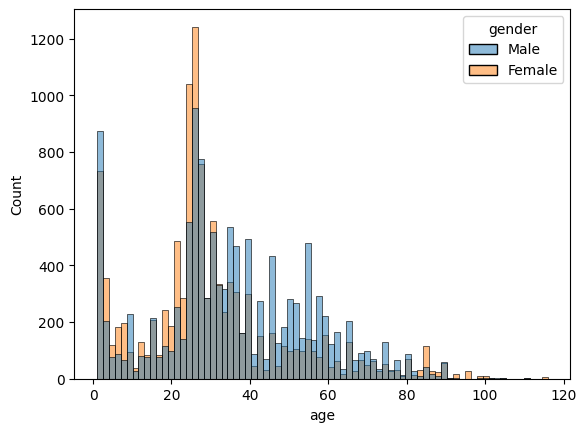

In [12]:
sns.histplot(data=df,x="age",hue="gender")

53
2
27
29
42


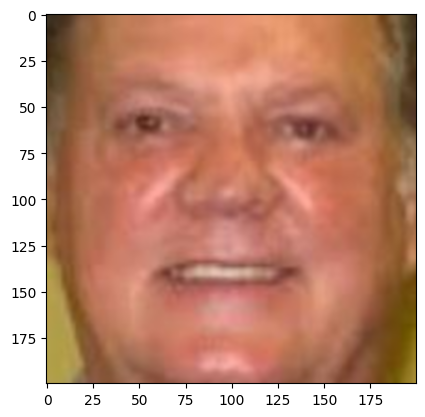

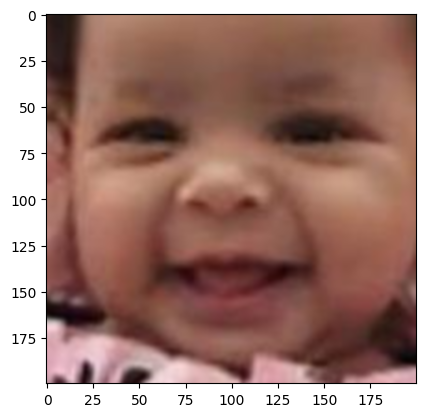

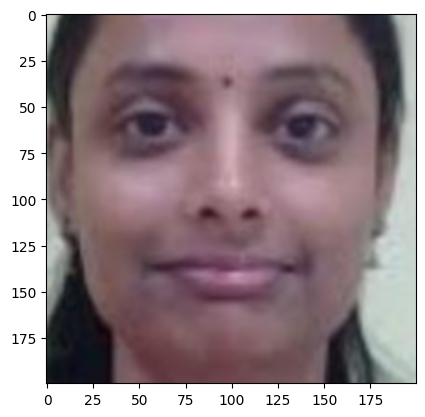

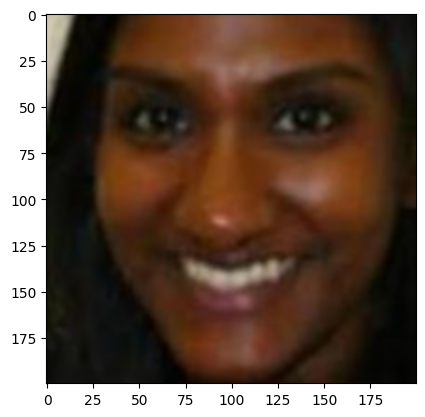

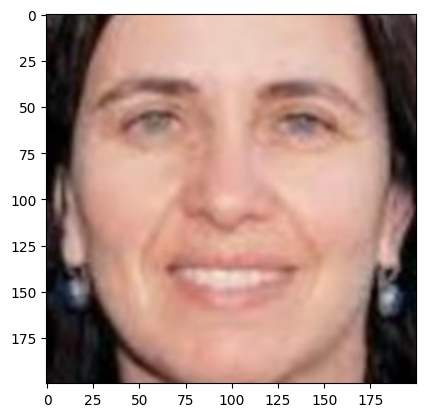

In [8]:
from turtle import title
from torchvision import transforms

for i in range(5):
    img, label = dataset[i]
    plt.figure()
    print(int(label))
    plt.imshow(transforms.ToPILImage()(img), interpolation="bicubic")

In [9]:
os.makedirs("data/train", exist_ok=True)
os.makedirs("data/val", exist_ok=True)
os.makedirs("data/test", exist_ok=True)

In [10]:
df=df.sort_values("age")

In [13]:
import shutil
import os

In [47]:
for i in range(10):
    if i==0:
        save_dir="data/test"
    elif i==1:
        save_dir="data/val"
    else:
        save_dir="data/train"

    for img in list(df[i::10]["path"]):
        shutil.copyfile(img,os.path.join(save_dir,img.split("/")[-1]))

In [14]:
import os

In [15]:
len(os.listdir("data/val"))

2371

In [16]:
len(os.listdir("data/test"))

2371

In [17]:
len(os.listdir("data/train"))

18966

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet

In [56]:
"""
VGG implementation from [InterDigitalInc](https://github.com/InterDigitalInc/HRFAE/blob/master/nets.py)
"""

class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        # vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.fc6 = nn.Linear(25088, 4096, bias=True)
        self.fc7 = nn.Linear(4096, 4096, bias=True)
        self.fc8_101 = nn.Linear(4096, 101, bias=True)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # input_w: 224                  
        # input_h: 224
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['p3'] = self.pool3(out['r33'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['p4'] = self.pool4(out['r43'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['p5'] = self.pool5(out['r53'])
        out['p5'] = out['p5'].view(out['p5'].size(0), -1)
        out['fc6'] = F.relu(self.fc6(out['p5']))
        out['fc7'] = F.relu(self.fc7(out['fc6']))
        out['fc8'] = self.fc8_101(out['fc7'])
        return out

In [57]:
model_benchmark=VGG()

In [58]:
model_benchmark.load_state_dict(torch.load("models/dex_age_classifier.pth")["state_dict"])
model_benchmark.eval()

VGG(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_3): Conv2d(512, 512,

In [74]:
dataset[10][1]

tensor([80.])

In [73]:
model_benchmark.forward(transforms.Resize((224,224),antialias=True)(dataset[10][0].reshape(-1,3,200,200).float()))['fc8'].argmax()

tensor(90)

In [11]:
class PretrainedEfficientNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = EfficientNet.from_pretrained("efficientnet-b0", num_classes=1)

    def forward(self, x):
        x = self.model(x.float())
        return x

In [26]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pytorch_lightning as pl
from torchmetrics import MeanAbsoluteError as MAE
from torchmetrics import MeanMetric, MinMetric

In [13]:
class LightningWrapper(pl.LightningModule):
    def __init__(self, net):
        
        super().__init__()

        # this line allows to access init params with 'self.hparams' attribute
        self.save_hyperparameters(ignore=['net'])
        
        # architecture
        self.net=net

        # loss function
        self.criterion = torch.nn.MSELoss()

        # metric objects for calculating and averaging MAE across batches
        self.train_mae = MAE()
        self.val_mae = MAE()
        self.test_mae = MAE()

        # for averaging loss across batches
        self.train_loss = MeanMetric()
        self.val_loss = MeanMetric()
        self.test_loss = MeanMetric()

        # for tracking best so far validation accuracy
        self.val_mae_best = MinMetric()

        self.validation_step_outputs = []

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        return self.net(x)

    def model_step(self, batch):
        x, y = batch
        preds = self.forward(x)
        loss = self.criterion(preds, y)
        return loss, preds, y

    def training_step(self, batch, batch_idx):
        loss, preds, targets = self.model_step(batch)

        self.train_loss(loss)
        self.train_mae(preds, targets)
        self.log("train/loss", self.train_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train/mae", self.train_mae, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def on_train_start(self):
        self.val_mae_best.reset()

    def validation_step(self, batch, batch_idx):
        loss, preds, targets = self.model_step(batch)

        self.val_loss(loss)
        self.val_mae(preds, targets)
        self.log("val/loss", self.val_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val/mae", self.val_mae, on_step=False, on_epoch=True, prog_bar=True)

    def on_validation_epoch_end(self):
        self.val_mae_best(self.val_mae.compute())
        self.log("val/mae_best", self.val_mae_best.compute(), prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, preds, targets = self.model_step(batch)

        self.test_loss(loss)
        self.test_mae(preds, targets)
        self.log("test/loss", self.test_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test/mae", self.test_mae, on_step=False, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        return optimizer

In [14]:
from pytorch_lightning import LightningDataModule
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [47]:
from torchsampler import ImbalancedDatasetSampler

In [68]:
def clip_age(x):
    return np.clip(x, a_min=0,a_max=100)

In [15]:
class FaceDataModule(LightningDataModule):

    def __init__(
        self,
        data_dir: str = "data/",
        img_size: tuple = (224, 224),
        batch_size: int = 32,
        num_workers: int = 0,
        pin_memory: bool = False,
    ):
        super().__init__()

        # this line allows to access init params with 'self.hparams' attribute
        # also ensures init params will be stored in ckpt
        self.save_hyperparameters()

        self.data_train = None
        self.data_val = None
        self.data_test = None

    def setup(self, stage):
        if not self.data_train and not self.data_val and not self.data_test:

            # image transformations
            transform_list = []
            transform_list.append(transforms.Resize(self.hparams.img_size,antialias=True))
            transform_list.append(transforms.RandomHorizontalFlip(p=0.5))
            transform_list.append(transforms.ColorJitter(brightness=0.2))
            transform = transforms.Compose(transform_list)

            # cap age
            target_transform=clip_age
            
            self.data_train = FaceDataset(
                img_dir="data/train",
                transform=transform,
                target_transform=target_transform
            )
            self.data_val = FaceDataset(
                img_dir="data/val",
                transform=transform,
                target_transform=target_transform
            )
            self.data_test = FaceDataset(
                img_dir="data/test",
                transform=transform,
                target_transform=target_transform
            )

    def train_dataloader(self):
        return DataLoader(
            dataset=self.data_train,
            sampler=ImbalancedDatasetSampler(self.data_train)
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.data_val,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )

    def test_dataloader(self):
        return DataLoader(
            dataset=self.data_test,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )

In [16]:
net = PretrainedEfficientNet()

model = LightningWrapper(net=net)

Loaded pretrained weights for efficientnet-b0


In [17]:
data_dir = "data/"
log_dir = "logs/"

img_size = (224, 224)

datamodule = FaceDataModule(
    data_dir=data_dir,
    img_size=img_size,
    num_workers=6,
    batch_size=32,
    pin_memory=False,
)

In [18]:
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger

In [19]:
callbacks = []
loggers = []

callbacks.append(
    pl.callbacks.ModelCheckpoint(
        monitor="val/loss",
        dirpath=log_dir + "checkpoints",
        save_top_k=1,
        save_last=True,
        mode="min",
        save_weights_only=True,
        filename="best-checkpoint",
    )
)

model_name=f"EffNet+{img_size}"
model_group=f"EffNet+{img_size}"

logger = TensorBoardLogger(log_dir, name=model_name)
logger2 = CSVLogger(log_dir, name=model_name)

loggers.append(
    logger
)

loggers.append(
    logger2
)

In [27]:
trainer = pl.Trainer(
        accelerator="gpu",
        default_root_dir=log_dir,
        callbacks=callbacks,
        logger=loggers,
        max_epochs=2,
        val_check_interval=0.1,  # frequency of validation epoch
    )

pl.seed_everything(123)
# validate before training
trainer.validate(model=model, datamodule=datamodule)

# train
trainer.fit(model=model, datamodule=datamodule)

# test
trainer.test(model=model, datamodule=datamodule, ckpt_path="best")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/EffNet+(224, 224)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████████████| 75/75 [00:10<00:00,  7.40it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val/loss          │       24468.796875        │
│          val/mae          │    104.31053924560547     │
│       val/mae_best        │    104.31053924560547     │
└───────────────────────────┴───────────────────────────┘

/home/olafw/anaconda3/envs/age_detection/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /home/olafw/Desktop/Age_Detector/logs/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type                   | Params
--------------------------------------------------------
0 | net          | PretrainedEfficientNet | 4.0 M 
1 | criterion    | MSELoss                | 0     
2 | train_mae    | MeanAbsoluteError      | 0     
3 | val_mae      | MeanAbsoluteError      | 0     
4 | test_mae     | MeanAbsoluteError      | 0     
5 | train_loss   | MeanMetric             | 0     
6 | val_loss     | MeanMetric             | 0     
7 | test_loss    | MeanMetric             | 0     
8 | val_mae_best | MinMetric              | 0     
--------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.035    Total estimated model p

Epoch 0:  10%|██▍                     | 59/593 [00:27<04:04,  2.18it/s, v_num=0]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 75/75 [00:09<00:00,  7.99it/s]
Epoch 0:  20%|▏| 118/593 [01:02<04:13,  1.87it/s, v_num=0, val/loss=2.62e+11, va
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 75/75 [00:09<00:00,  8.04it/s]
Epoch 0:  30%|▎| 177/593 [01:38<03:51,  1.80it/s, v_num=0, val/loss=2.58e+7, val
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 75/75 [00:09<00:00,  8.13it/s]
Epoch 0:  40%|▍| 236/593 [02:26<03:41,  1.61it/s, v_num=0, val/loss=794.0, val/m
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 75/75 [00:19<00:00,  3.83it/s]
Epoch 0:  50%|▍| 295/593 [03

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|█| 593/593 [12:43<00:00,  0.78it/s, v_num=0, val/loss=411.0, val/m


Restoring states from the checkpoint path at /home/olafw/Desktop/Age_Detector/logs/checkpoints/best-checkpoint-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/olafw/Desktop/Age_Detector/logs/checkpoints/best-checkpoint-v1.ckpt


Testing DataLoader 0: 100%|█████████████████████| 75/75 [00:17<00:00,  4.35it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/loss         │    111.04580688476562     │
│         test/mae          │     7.556758403778076     │
└───────────────────────────┴───────────────────────────┘

NameError: name 'use_wandb' is not defined

In [18]:
checkpoint = torch.load("logs/checkpoints/last.ckpt")

In [37]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [38]:
%tensorboard --logdir logs/EffNet+\(224,\ 224\)

In [22]:
checkpoint['datamodule_hyper_parameters']

{'data_dir': 'data/',
 'img_size': (224, 224),
 'batch_size': 32,
 'num_workers': 6,
 'pin_memory': False}

In [20]:
checkpoint.keys()

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'datamodule_hparams_name', 'datamodule_hyper_parameters'])

In [14]:
model=model.load_from_checkpoint("logs/checkpoints/best-checkpoint.ckpt",net=net)#.eval()

In [49]:
all_preds = []
all_targets = []

for x, y in datamodule.test_dataloader():

    preds = model.forward(x)
    preds = preds.detach()
    
    preds = preds.cpu().numpy()
    targets = y.cpu().numpy()
    
    all_preds.append(preds)
    all_targets.append(targets)

NameError: name 'np' is not defined

In [51]:
all_preds = np.concatenate(all_preds).astype(int)
all_targets = np.concatenate(all_targets).astype(int)

In [52]:
all_preds

array([[57],
       [39],
       [58],
       ...,
       [42],
       [43],
       [18]])

In [53]:
all_targets

array([[56],
       [47],
       [80],
       ...,
       [47],
       [26],
       [36]])

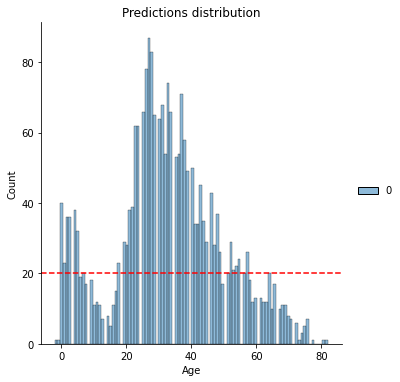

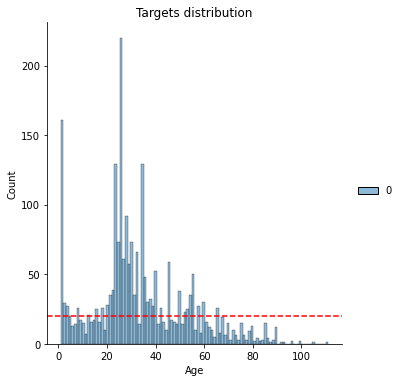

In [55]:
sns.displot(all_preds,label="Predictions", bins=100)
plt.xlabel("Age")
plt.title("Predictions distribution")
plt.axhline(y=20, color="r", ls="--")

plt.show()

sns.displot(all_targets, label="Targets", bins=100)
plt.xlabel("Age")
plt.title("Targets distribution")
plt.axhline(y=20, color="r", ls="--")

plt.show()

In [60]:
np.abs((all_preds-all_targets)).mean()

7.592155208772669

In [44]:
datamodule.test_dataloader()

In [54]:
dataset[1][0].shape

torch.Size([3, 200, 200])

# Example image to make younger

In [15]:
test_sample=dataset[500][0].reshape([1,3,200,200]).to('cuda').float().requires_grad_()

In [240]:
target_age=torch.tensor([[60.]]).to('cuda')

In [241]:
new_photo=test_sample
new_photo.retain_grad()
learning_rate=1.
for i in range(15):

    print(i)
    pred=model.forward(new_photo)
    model.criterion(pred,target_age).backward(retain_graph=True)
    
    new_photo=new_photo-new_photo.grad*learning_rate
    new_photo.grad=None
    model.net.zero_grad()
    new_photo.retain_grad()
    new_photo.requires_grad_()

    print(pred)
    if model.criterion(pred,target_age)<10:
        print('xd')

0
tensor([[23.2737]], device='cuda:0', grad_fn=<AddmmBackward0>)
1
tensor([[25.1858]], device='cuda:0', grad_fn=<AddmmBackward0>)
2
tensor([[27.3697]], device='cuda:0', grad_fn=<AddmmBackward0>)
3
tensor([[29.9511]], device='cuda:0', grad_fn=<AddmmBackward0>)
4
tensor([[33.3102]], device='cuda:0', grad_fn=<AddmmBackward0>)
5
tensor([[37.5840]], device='cuda:0', grad_fn=<AddmmBackward0>)
6
tensor([[42.0271]], device='cuda:0', grad_fn=<AddmmBackward0>)
7
tensor([[46.2327]], device='cuda:0', grad_fn=<AddmmBackward0>)
8
tensor([[50.2211]], device='cuda:0', grad_fn=<AddmmBackward0>)
9
tensor([[53.8225]], device='cuda:0', grad_fn=<AddmmBackward0>)
10
tensor([[56.3131]], device='cuda:0', grad_fn=<AddmmBackward0>)
11
tensor([[57.7504]], device='cuda:0', grad_fn=<AddmmBackward0>)
xd
12
tensor([[58.5860]], device='cuda:0', grad_fn=<AddmmBackward0>)
xd
13
tensor([[59.0920]], device='cuda:0', grad_fn=<AddmmBackward0>)
xd
14
tensor([[59.4089]], device='cuda:0', grad_fn=<AddmmBackward0>)
xd


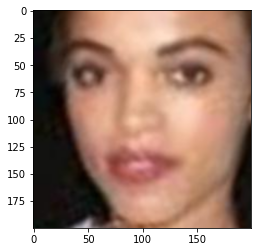

In [242]:
plt.imshow(transforms.ToPILImage()(test_sample.reshape(3,200,200).to(torch.uint8)), interpolation="bicubic")

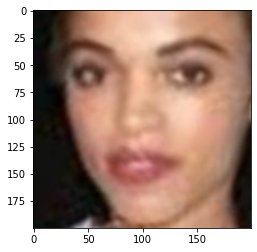

In [243]:
plt.imshow(transforms.ToPILImage()(new_photo.reshape(3,200,200).to(torch.uint8)), interpolation="bicubic")

In [244]:
diff_photo=test_sample-new_photo

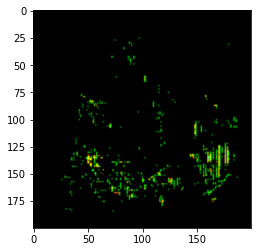

In [245]:
plt.imshow(transforms.ToPILImage()(diff_photo.reshape(3,200,200).to(torch.uint8)), interpolation="bicubic")

In [64]:
mama=read_image("mama.jpg").rot90(-1,[1,2])

In [65]:
mama=transforms.Resize((224,224),antialias=True)(mama)

In [66]:
tata=read_image("tata.jpg").rot90(-1,[1,2])

In [67]:
tata=transforms.Resize((224,224),antialias=True)(tata)

In [68]:
mama.shape

torch.Size([3, 224, 224])

In [69]:
model(mama.reshape([1,3,224,224]).to('cuda').float())

tensor([[35.5670]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [70]:
model(tata.reshape([1,3,224,224]).to('cuda').float())

tensor([[34.2304]], device='cuda:0', grad_fn=<AddmmBackward0>)

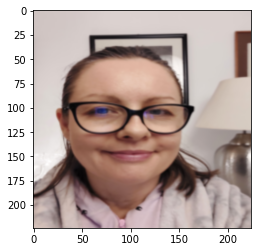

In [71]:
plt.imshow(transforms.ToPILImage()(mama.reshape(3,224,224).to(torch.uint8)), interpolation="bicubic")

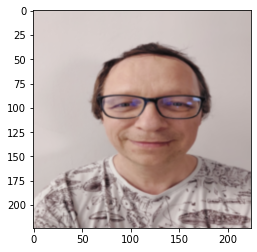

In [72]:
plt.imshow(transforms.ToPILImage()(tata.reshape(3,224,224).to(torch.uint8)), interpolation="bicubic")

In [55]:
mama=mama.rot90(k=-1,[1,2])

In [56]:
mama.shape

torch.Size([3, 2448, 3264])